# Computes domain mean rain rate time-series and histogram and save to netCDF files
- Include convective/stratiform rain separation using first step cell tracking files (all times concatenated)
- Use composite rain rate file (all times concatenated)

In [1]:
import os
import glob, time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import pandas as pd

In [3]:
datadir = '/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/'
# Composite rain rate file (all times concatenated)
rainfile = f'{datadir}taranis_corcsapr2cfrppiqcM1_composite_rain.c1.concat/cacti_composite_rain.nc'
# Convective/stratiform file (all times concatenated)
convsffile = f'{datadir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.v2/tracking/cacti_convsf.nc'

# Output files
outdir = f'/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.v2/stats/'
outfile = f'{outdir}csapr2_domain_mean_rain_20181015_20190303.nc'
outfile_pdf = f'{outdir}csapr2_rainrate_pdf_20181015_20190303.nc'

figdir = f'/gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.v2/figures/celltrack_stats/'
os.makedirs(figdir, exist_ok=True)

In [4]:
# datadir = '/global/cscratch1/sd/feng045/iclass/cacti/arm/csapr/'
# rainfile = f'{datadir}taranis_corcsapr2cfrppiqcM1_composite_rain.c1/cacti_composite_rain.nc'
# convsffile = f'{datadir}taranis_corcsapr2cfrppiqcM1_gridded_convmask.c1/cacti_convsf.nc'

# outdir = f'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
# outfile = f'{outdir}csapr2_domain_mean_rain_20181015_20190303.nc'
# outfile_pdf = f'{outdir}csapr2_rainrate_pdf_20181015_20190303.nc'

# iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'

In [19]:
# Read rain rate file
dsr = xr.open_dataset(rainfile)
dsr

<xarray.Dataset> Size: 27GB
Dimensions:                             (x: 441, y: 441, time: 8721)
Coordinates:
  * x                                   (x) int64 4kB -110000 -109500 ... 110000
  * y                                   (y) int64 4kB -110000 -109500 ... 110000
  * time                                (time) datetime64[ns] 70kB 2018-10-15...
Data variables:
    taranis_composite_rain_rate         (time, y, x) float64 14GB ...
    taranis_composite_rain_rate_height  (time, y, x) float64 14GB ...
    lat                                 float64 8B ...
    lon                                 float64 8B ...
    alt                                 float64 8B ...
    origin_latitude                     float64 8B ...
    origin_longitude                    float64 8B ...
    point_latitude                      (x, y) float64 2MB ...
    point_longitude                     (x, y) float64 2MB ...
    point_x                             (x, y) int64 2MB ...
    point_y                             (x, y) int64 2MB ...
Attributes: (12/32)
    command_line:          sapr2cfrqc -D 2 -s cor -f M1 -R -n csapr2cfrppiqc ...
    Conventions:           ARM-1.2 CF/Radial-1.4 instrument_parameters radar_...
    process_version:       ingest-sapr2cfrqc-0.0-0.dev0.dirty.el7
    dod_version:           csapr2cfrppiqc-b1-1.0
    input_source:          /data/reproc/D190625.1/collection/cor/corcsaprM1.0...
    site_id:               cor
    ...                    ...
    title:                 ARM CSAPR2 Moments B1
    transform_history:     Offset from file '/home/schuman/apps/process/conf/...
    doi:                   10.5439/1467901
    history:               created by user schuman on machine or-condo-c224.o...
    source_filename:       /home/josephhardinee/data/proj-shared/data_transfe...
    output_filename:       /home/josephhardinee/data/proj-shared/iclass/cacti...

In [20]:
# Read convective/stratiform file
dsc = xr.open_dataset(convsffile)
dsc

<xarray.Dataset> Size: 21GB
Dimensions:    (lat: 441, lon: 441, time: 8881)
Coordinates:
  * time       (time) datetime64[ns] 71kB 2018-10-15T00:00:03 ... 2019-03-02T...
  * lon        (lon) float64 4kB -65.91 -65.9 -65.9 ... -63.56 -63.55 -63.55
  * lat        (lat) float64 4kB -33.11 -33.11 -33.1 ... -31.14 -31.14 -31.13
Data variables:
    longitude  (lat, lon) float64 2MB ...
    latitude   (lat, lon) float64 2MB ...
    dbz_comp   (time, lat, lon) float32 7GB ...
    convsf     (time, lat, lon) int64 14GB ...
Attributes: (12/22)
    Title:                Cloudid file from 2018-10-15 00:00 UTC
    Contact:              Zhe Feng, zhe.feng@pnnl.gov
    Institution:          Pacific Northwest National Laboratory
    Created_on:           Wed Oct 30 20:35:28 2024
    Input_File:           /gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csap...
    dx:                   500
    ...                   ...
    weakEchoThres:        15
    bkgrndRadius:         11
    min_corearea:         4
    echotop_gap:          4
    sfc_dz_min:           500
    sfc_dz_max:           3000

In [54]:
# Drop coordinates and dimensions in dsc
dsc_ = dsc.reset_coords(drop=True)
dsc_ = dsc_.drop_vars(['lon','lat','longitude','latitude'])
# Assign coordinates from dsr to dsc
dsc_ = dsc_.assign_coords({'x':dsr['x'], 'y':dsr['y']})
# Change the dimension names
dsc_ = dsc_.rename({'lat': 'y', 'lon': 'x'})

In [57]:
# Combine two datasets, set join='inner' to use the intersection of object indexes
ds = xr.merge([dsr, dsc_], join='inner')
ds

<xarray.Dataset> Size: 47GB
Dimensions:                             (x: 441, y: 441, time: 8721)
Coordinates:
  * x                                   (x) int64 4kB -110000 -109500 ... 110000
  * y                                   (y) int64 4kB -110000 -109500 ... 110000
  * time                                (time) datetime64[ns] 70kB 2018-10-15...
Data variables: (12/13)
    taranis_composite_rain_rate         (time, y, x) float64 14GB ...
    taranis_composite_rain_rate_height  (time, y, x) float64 14GB ...
    lat                                 float64 8B ...
    lon                                 float64 8B ...
    alt                                 float64 8B ...
    origin_latitude                     float64 8B ...
    ...                                  ...
    point_latitude                      (x, y) float64 2MB ...
    point_longitude                     (x, y) float64 2MB ...
    point_x                             (x, y) int64 2MB ...
    point_y                             (x, y) int64 2MB ...
    dbz_comp                            (time, y, x) float32 7GB ...
    convsf                              (time, y, x) int64 14GB ...
Attributes: (12/32)
    command_line:          sapr2cfrqc -D 2 -s cor -f M1 -R -n csapr2cfrppiqc ...
    Conventions:           ARM-1.2 CF/Radial-1.4 instrument_parameters radar_...
    process_version:       ingest-sapr2cfrqc-0.0-0.dev0.dirty.el7
    dod_version:           csapr2cfrppiqc-b1-1.0
    input_source:          /data/reproc/D190625.1/collection/cor/corcsaprM1.0...
    site_id:               cor
    ...                    ...
    title:                 ARM CSAPR2 Moments B1
    transform_history:     Offset from file '/home/schuman/apps/process/conf/...
    doi:                   10.5439/1467901
    history:               created by user schuman on machine or-condo-c224.o...
    source_filename:       /home/josephhardinee/data/proj-shared/data_transfe...
    output_filename:       /home/josephhardinee/data/proj-shared/iclass/cacti...

In [60]:
# # Combine two datasets, set join='inner' to use the intersection of object indexes
# ds = xr.merge([dsr, dsc], join='inner')
# ds

In [61]:
# Select a time, cut out the western portion of domain where blockage is significant
# Count the non-NaN values to get the east domain number of pixels
xmin = -25000
xmax = 110000
rr = ds.taranis_composite_rain_rate.isel(time=0).sel(x=slice(xmin,xmax))
npix_EastDomain = np.count_nonzero(~np.isnan(rr))

In [62]:
ds.convsf.attrs

{'long_name': 'Steiner Convective/Stratiform classification',
 'units': 'unitless',
 'comment': 'NAN:0, NO_SURF_ECHO:1, WEAK_ECHO:2, STRATIFORM:3, CONVECTIVE:4'}

In [63]:
# rr_bins = np.arange(0, 300.1, 1)
rr_bins = np.logspace(np.log10(0.1), np.log10(300), num=100)
hist_rr_total, bins = np.histogram(ds.taranis_composite_rain_rate.sel(x=slice(xmin, xmax)), bins=rr_bins, range=(min(rr_bins), max(rr_bins)), density=False)
hist_rr_conv, bins = np.histogram(ds.taranis_composite_rain_rate.where(ds.convsf == 4).sel(x=slice(xmin, xmax)), bins=rr_bins, range=(min(rr_bins), max(rr_bins)), density=False)
hist_rr_strat, bins = np.histogram(ds.taranis_composite_rain_rate.where(ds.convsf == 3).sel(x=slice(xmin, xmax)), bins=rr_bins, range=(min(rr_bins), max(rr_bins)), density=False)

In [64]:
pdf_rr_total, bins = np.histogram(ds.taranis_composite_rain_rate.sel(x=slice(xmin, xmax)), bins=rr_bins, range=(min(rr_bins), max(rr_bins)), density=True)
pdf_rr_conv, bins = np.histogram(ds.taranis_composite_rain_rate.where(ds.convsf == 4).sel(x=slice(xmin, xmax)), bins=rr_bins, range=(min(rr_bins), max(rr_bins)), density=True)
pdf_rr_strat, bins = np.histogram(ds.taranis_composite_rain_rate.where(ds.convsf == 3).sel(x=slice(xmin, xmax)), bins=rr_bins, range=(min(rr_bins), max(rr_bins)), density=True)

In [65]:
rr_bin_vals = rr_bins[:-1] + np.diff(rr_bins)/2.

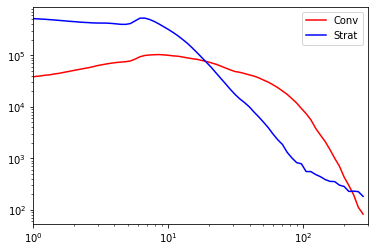

In [66]:
plt.plot(rr_bins[:-1], hist_rr_conv, color='r', label='Conv')
plt.plot(rr_bins[:-1], hist_rr_strat, color='b', label='Strat')
plt.legend()
plt.yscale('log')
plt.xlim(1, 300)
plt.xscale('log')

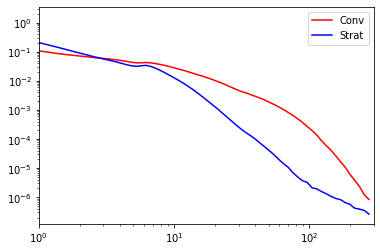

In [67]:
plt.plot(rr_bins[:-1], pdf_rr_conv, color='r', label='Conv')
plt.plot(rr_bins[:-1], pdf_rr_strat, color='b', label='Strat')
plt.legend()
plt.yscale('log')
plt.xlim(1, 300)
plt.xscale('log')

## Save rain rate histogram to netCDF file

In [68]:
# Define DataSet for histogram
var_dict = {
    'hist_rain_total': (['bin'], hist_rr_total), \
    'hist_rain_convective': (['bin'], hist_rr_conv), \
    'hist_rain_stratiform': (['bin'], hist_rr_strat), \
    'pdf_rain_total': (['bin'], pdf_rr_total), \
    'pdf_rain_convective': (['bin'], pdf_rr_conv), \
    'pdf_rain_stratiform': (['bin'], pdf_rr_strat), \
}
coord_dict = {'bin': (['bin'], rr_bin_vals)}
gattr_dict = {
    'title': 'CACTI CSAPR2 eastern domain precipitation PDF', \
    'xmin_meter': xmin, \
    'xmax_meter': xmax, \
    'contact':'Zhe Feng, zhe.feng@pnnl.gov', \
    'created_on':time.ctime(time.time()),
}
dsout = xr.Dataset(data_vars=var_dict, coords=coord_dict, attrs=gattr_dict)

dsout['bin'].attrs['long_name'] = 'Rain rate bin center values'
dsout['bin'].attrs['units'] = 'mm/h'
dsout['hist_rain_total'].attrs['long_name'] = 'Total precipitation'
dsout['hist_rain_total'].attrs['units'] = 'counts'
dsout['hist_rain_convective'].attrs['long_name'] = 'Convective precipitation'
dsout['hist_rain_convective'].attrs['units'] = 'counts'
dsout['hist_rain_stratiform'].attrs['long_name'] = 'Stratiform precipitation'
dsout['hist_rain_stratiform'].attrs['units'] = 'counts'
dsout['pdf_rain_total'].attrs['long_name'] = 'Total precipitation'
dsout['pdf_rain_total'].attrs['units'] = 'frequency'
dsout['pdf_rain_convective'].attrs['long_name'] = 'Convective precipitation'
dsout['pdf_rain_convective'].attrs['units'] = 'frequency'
dsout['pdf_rain_stratiform'].attrs['long_name'] = 'Stratiform precipitation'
dsout['pdf_rain_stratiform'].attrs['units'] = 'frequency'

# Set encoding/compression for all variables
comp = dict(zlib=True, dtype='float32')
# Write to output netCDF
encoding = {var: comp for var in dsout.data_vars}
# Update base_time variable dtype as 'double' for better precision
# time_dict = {'time': {'zlib':True, 'dtype':'float64'}}
# encoding.update(time_dict)
dsout.to_netcdf(path=outfile_pdf, mode='w', format='NETCDF4', encoding=encoding)
print(f'Saved: {outfile_pdf}')

Saved: /gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.v2/stats/csapr2_rainrate_pdf_20181015_20190303.nc


## Compute domain mean rain rate time-series

In [69]:
rr_total = ds.taranis_composite_rain_rate.sel(x=slice(xmin, xmax)).sum(dim=('x','y')) / npix_EastDomain

In [70]:
rr_conv = ds.taranis_composite_rain_rate.where(ds.convsf == 4).sel(x=slice(xmin, xmax)).sum(dim=('x','y')) / npix_EastDomain
rr_strat = ds.taranis_composite_rain_rate.where(ds.convsf == 3).sel(x=slice(xmin, xmax)).sum(dim=('x','y')) / npix_EastDomain

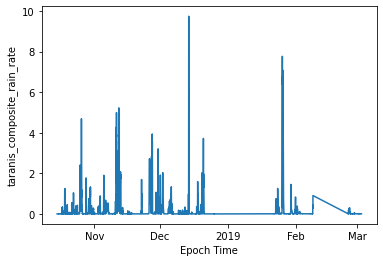

In [71]:
rr_total.plot()

In [72]:
# # Create a standard time series bins
# date_ts = pd.date_range(start='2018-10-15T00', end='2019-03-02T23', freq='6H')
# # Make bounds for pcolormesh
# date_ts_bounds = pd.date_range(start='2018-10-15T00', end='2019-03-03T00', freq='6H')
# ndate_ts = len(date_ts)
# print(date_ts)
# print(date_ts.shape, date_ts_bounds.shape)

In [73]:
# date_ts15min = pd.date_range(start='2018-10-15T00', end='2019-03-02T23', freq='15min')
# rr_total_interp = rr_total.interp(time=date_ts15min, method='nearest')
# rr_total_interp.plot()

## Save domain mean rain rate time-series to netCDF file

In [76]:
# Time coordinate
time_out = rr_total.time

# Define xarray dataset
var_dict = {
    'rain': (['time'], rr_total.data), \
    'rain_convective': (['time'], rr_conv.data), \
    'rain_stratiform': (['time'], rr_strat.data), \
}
coord_dict = {'time': (['time'], time_out.data, time_out.attrs)}
gattr_dict = {
    'title': 'CACTI CSAPR2 eastern domain mean precipitation', \
    'xmin_meter': xmin, \
    'xmax_meter': xmax, \
    'contact':'Zhe Feng, zhe.feng@pnnl.gov', \
    'created_on':time.ctime(time.time()),
}
dsout = xr.Dataset(data_vars=var_dict, coords=coord_dict, attrs=gattr_dict)

dsout['rain'].attrs['long_name'] = 'Total precipitation'
dsout['rain'].attrs['units'] = 'mm/h'
dsout['rain_convective'].attrs['long_name'] = 'Convective precipitation'
dsout['rain_convective'].attrs['units'] = 'mm/h'
dsout['rain_stratiform'].attrs['long_name'] = 'Stratiform precipitation'
dsout['rain_stratiform'].attrs['units'] = 'mm/h'

# Set encoding/compression for all variables
comp = dict(zlib=True, dtype='float32')
# Write to output netCDF
encoding = {var: comp for var in dsout.data_vars}
# Update base_time variable dtype as 'double' for better precision
time_dict = {'time': {'zlib':True, 'dtype':'float64'}}
encoding.update(time_dict)
dsout.to_netcdf(path=outfile, mode='w', format='NETCDF4', unlimited_dims='time', encoding=encoding)
print(f'Saved: {outfile}')

Saved: /gpfs/wolf2/arm/atm131/proj-shared/zfeng/cacti/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.v2/stats/csapr2_domain_mean_rain_20181015_20190303.nc


## Resample time-series to a coarser resolution for plotting 

In [78]:
# Resample time series to a coarser resolution
rr_total_6H = rr_total.resample(time='6h').mean()
rr_conv_6H = rr_conv.resample(time='6h').mean()
rr_strat_6H = rr_strat.resample(time='6h').mean()
time_6H = rr_total_6H.time

In [79]:
# rr_total_avg = rr_total_6H.where(rr_total_6H > 0.001).mean().values
# rr_conv_avg = rr_conv_6H.where(rr_conv_6H > 0.001).mean().values
# rr_strat_avg = rr_strat_6H.where(rr_strat_6H > 0.001).mean().values
# rr_total_avg = rr_total.where(rr_total > 0.001).mean().values
# rr_conv_avg = rr_conv.where(rr_total > 0.001).mean().values
# rr_strat_avg = rr_strat.where(rr_total > 0.001).mean().values
rr_total_avg = rr_total.mean().values
rr_conv_avg = rr_conv.mean().values
rr_strat_avg = rr_strat.mean().values
print(f'Total: {rr_total_avg}, Conv: {rr_conv_avg}, Strat: {rr_strat_avg}')

Total: 0.18595443779219153, Conv: 0.06444628730008428, Strat: 0.10187360813747257


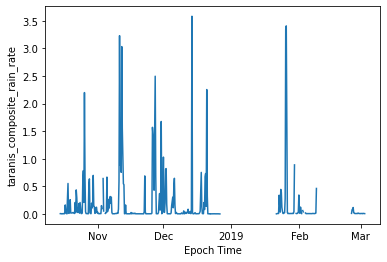

In [80]:
rr_total_6H.plot()

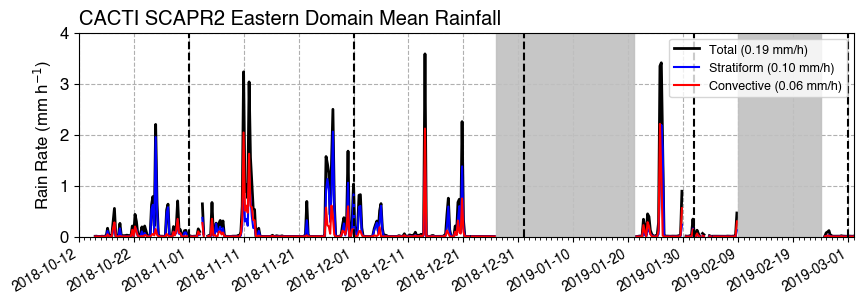

In [81]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax = plt.subplots(1, 1, figsize=[10,3], dpi=100)

outtimes1 = [pd.Timestamp('2018-12-27T00'),  pd.Timestamp('2019-2-9T00')]
outtimes2 = [pd.Timestamp('2019-1-21T00'),  pd.Timestamp('2019-2-24T00')]
monthday1 = pd.date_range(start='2018-10-1', end='2019-3-1', freq='1MS')
xlims = [pd.Timestamp('2018-10-12T00'), pd.Timestamp('2019-3-2T00')]

ax.plot(time_6H, rr_total_6H, color='k', lw=2, label=f'Total ({rr_total_avg:.02f} mm/h)')
ax.plot(time_6H, rr_strat_6H, color='blue', lw=1.5, label=f'Stratiform ({rr_strat_avg:.02f} mm/h)')
ax.plot(time_6H, rr_conv_6H, color='red', lw=1.5, label=f'Convective ({rr_conv_avg:.02f} mm/h)')
# time_fmt = mdates.DateFormatter('%b %d')
time_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', labelsize=10)
ax.set_ylabel('Rain Rate (mm h$^{-1}$)')
ax.set_xlim(xlims[0], xlims[1])
ax.set_ylim(0,4)
ax.grid(which='major', ls='--')
ax.legend(fontsize=9, loc='upper right')
# Plot outtage times
for ii in range(len(outtimes1)):
    ax.axvspan(outtimes1[ii], outtimes2[ii], color='silver',alpha=0.9,zorder=2)
for ii in range(len(monthday1)):
    ax.axvline(monthday1[ii], color='k', ls='--', lw=1.5)
ax.set_title('CACTI SCAPR2 Eastern Domain Mean Rainfall', loc='left')

fig.autofmt_xdate()
fig.savefig(f'{figdir}rain_timeseries_fullcampaign.png', bbox_inches='tight', dpi=300, facecolor='w')

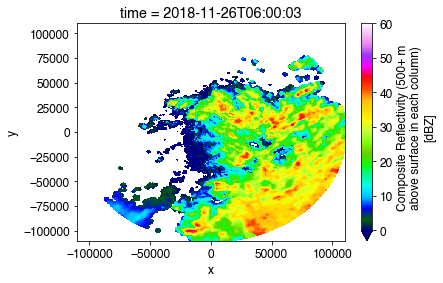

In [83]:
itime = '2018-11-26T06:00'
ds.sel(time=itime).dbz_comp.plot(vmin=0, vmax=60, cmap='gist_ncar')

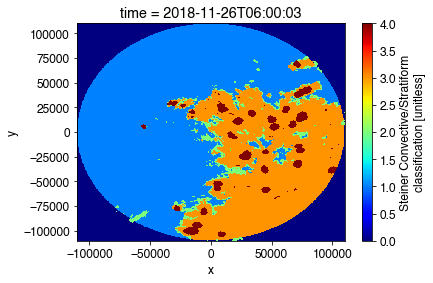

In [84]:
ds.sel(time=itime).convsf.plot(vmin=0, vmax=4, cmap='jet')

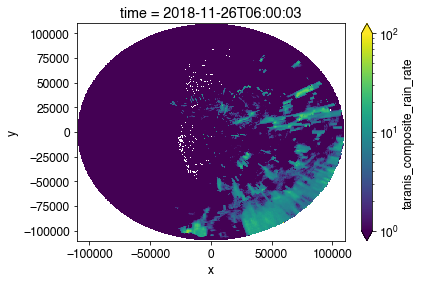

In [85]:
norm = mpl.colors.LogNorm(vmin=1, vmax=100)
ds.sel(time=itime).taranis_composite_rain_rate.plot(norm=norm)

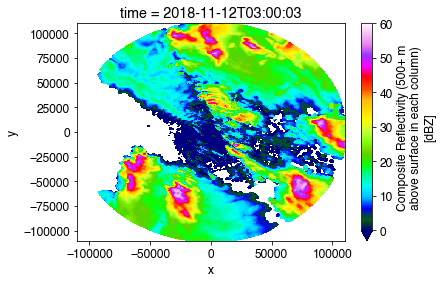

In [87]:
ds.sel(time='2018-11-12T0300').dbz_comp.plot(vmin=0, vmax=60, cmap='gist_ncar')

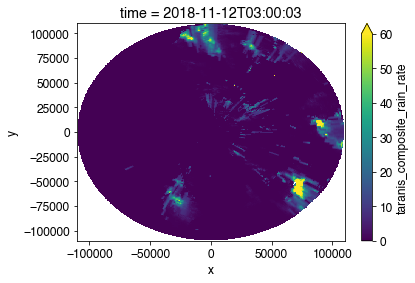

In [88]:
ds.sel(time='2018-11-12T0300').taranis_composite_rain_rate.plot(vmin=0, vmax=60)